# START / CONFIGURE SPARK

In [1]:
from pyspark.sql import SparkSession

# Stop any existing Spark session (useful in notebooks)
try:
    spark.stop()
    print("Old Spark session stopped.")
except Exception:
    print("No active Spark session — starting fresh.")

# Basic local Spark config (adjust cores/memory as needed)
SPARK_CORES   = 12          # Number of local cores to use
DRIVER_MEM    = "64g"       # Driver memory
SHUFFLE_PARTS = 320         # Global shuffle partitions

spark = (
    SparkSession.builder
        .appName("dk-housing-sqm-price")
        .master(f"local[{SPARK_CORES}]")
        .config("spark.driver.memory", DRIVER_MEM)
        .config("spark.sql.shuffle.partitions", str(SHUFFLE_PARTS))
        .config("spark.driver.maxResultSize", "4g")
        .config("spark.sql.adaptive.enabled", "true")
        .config("spark.sql.adaptive.coalescePartitions.enabled", "true")
        .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer")
        .getOrCreate()
)

spark


No active Spark session — starting fresh.


Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/27 23:41:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# LOAD PARQUET + FIX DATE/TIME COLUMNS

In [2]:
from pyspark.sql import functions as F

# Fix legacy Parquet timestamp behavior (needed for some older files)
spark.conf.set("spark.sql.legacy.parquet.nanosAsLong", "true")
spark.conf.set("spark.sql.legacy.parquet.int96RebaseMode", "CORRECTED")

# Load main cleaned dataset
df = spark.read.parquet("DKHousingPrices.parquet")

# Convert nanosecond epoch "date" → proper date, and extract time features
df = (
    df
    .withColumn(
        "date",
        F.to_date(
            F.from_unixtime(F.col("date") / 1_000_000_000)  # ns → s → timestamp → date
        )
    )
    .withColumn("year",   F.year("date"))
    .withColumn("month",  F.month("date"))
    # optional, not used later but nice to have:
    .withColumn("quarter", F.quarter("date"))
)

# Repartition for smoother downstream operations and cache in memory
SHUFFLE_PARTS = 200
df = df.repartition(SHUFFLE_PARTS).cache()

print("Materializing cache...")
row_count = df.count()

print("=" * 80)
print(f"SUCCESS! {row_count:,} Danish house sales loaded and cached")
print("=" * 80)
df.printSchema()

# Quick preview: newest and oldest sales
print("\nMost recent sales:")
df.select("date", "year", "quarter", "house_type", "purchase_price", "sqm") \
  .orderBy(F.desc("date")) \
  .show(5, truncate=False)

print("\nOldest sales:")
df.select("date", "year", "quarter", "house_type", "purchase_price", "sqm") \
  .orderBy(F.asc("date")) \
  .show(5, truncate=False)


Materializing cache...


SUCCESS! 1,507,908 Danish house sales loaded and cached
root
 |-- date: date (nullable = true)
 |-- quarter: integer (nullable = true)
 |-- house_id: long (nullable = true)
 |-- house_type: string (nullable = true)
 |-- sales_type: string (nullable = true)
 |-- year_build: short (nullable = true)
 |-- purchase_price: integer (nullable = true)
 |-- %_change_between_offer_and_purchase: float (nullable = true)
 |-- no_rooms: byte (nullable = true)
 |-- sqm: float (nullable = true)
 |-- sqm_price: float (nullable = true)
 |-- address: string (nullable = true)
 |-- zip_code: short (nullable = true)
 |-- city: string (nullable = true)
 |-- area: string (nullable = true)
 |-- region: string (nullable = true)
 |-- nom_interest_rate%: float (nullable = true)
 |-- dk_ann_infl_rate%: float (nullable = true)
 |-- yield_on_mortgage_credit_bonds%: float (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)


Most recent sales:
+----------+----+-------+---------

# DEFINE FEATURES + MISSING-VALUE CLEANING / IMPUTATION

In [3]:
from pyspark.sql.types import *
import pandas as pd
import time

# Feature lists (aligned with your dataset)
cat_nominal = ["house_type", "sales_type", "area", "region", "city"]
cat_zip     = ["zip_code"]

num_features = [
    "sqm",
    "%_change_between_offer_and_purchase",
    "nom_interest_rate%",
    "dk_ann_infl_rate%",
    "yield_on_mortgage_credit_bonds%",
    "year_build",
    "no_rooms",
    "year",
    "month",
]

feature_columns = cat_nominal + cat_zip + num_features
target = "sqm_price"

print(f"Total rows before any cleaning: {df.count():,}")

# ------------------------------------------------------------------
# 1) Missing-value analysis
# ------------------------------------------------------------------
start_time = time.time()
total_rows = df.count()

missing_summary = []
for col_name, col_type in df.dtypes:
    # Only inspect feature + target columns
    if col_name not in feature_columns + [target]:
        continue

    if col_type in ("float", "double", "int", "bigint", "smallint", "tinyint"):
        miss = df.filter(
            F.col(col_name).isNull() | F.isnan(F.col(col_name))
        ).count()
    else:
        miss = df.filter(F.col(col_name).isNull()).count()

    missing_summary.append((col_name, miss, round(miss / total_rows * 100, 4)))

miss_df = pd.DataFrame(missing_summary, columns=["Column", "Missing", "%"])
miss_df = miss_df.sort_values("%", ascending=False)

print("\nMISSING VALUES BEFORE CLEANING")
print(miss_df.to_string(index=False))

# No columns >95% missing → keep all
cols_to_drop = []
feature_columns = [c for c in feature_columns if c not in cols_to_drop]

# ------------------------------------------------------------------
# 2) Drop rows where ALL features are null (rare, but safe)
# ------------------------------------------------------------------
df = df.dropna(how="all", subset=feature_columns)

# ------------------------------------------------------------------
# 3) Drop rows with missing/NaN target (sqm_price)
# ------------------------------------------------------------------
df = df.filter(
    F.col(target).isNotNull() & ~F.isnan(F.col(target))
)
print(f"\nRows after removing missing target: {df.count():,}")

# ------------------------------------------------------------------
# 4) Build numeric vs categorical lists based on actual dtypes
# ------------------------------------------------------------------
numeric_cols = [
    c for c, t in df.dtypes
    if c in feature_columns
    and t in ("int", "bigint", "float", "double", "smallint", "tinyint")
]

categorical_cols = [
    c for c in feature_columns
    if c not in numeric_cols
]

print(f"\nNumeric columns to impute   : {len(numeric_cols)} → {numeric_cols}")
print(f"Categorical columns (fill 'missing') : {len(categorical_cols)} → {categorical_cols}")

# ------------------------------------------------------------------
# 5) Compute means for numeric columns
# ------------------------------------------------------------------
print("\nComputing means for numeric columns...")
mean_exprs = [F.mean(c).alias(f"mean_{c}") for c in numeric_cols]
means_row  = df.select(*mean_exprs).first()
mean_dict  = {c: means_row[f"mean_{c}"] for c in numeric_cols}
broadcast_means = spark.sparkContext.broadcast(mean_dict)

# ------------------------------------------------------------------
# 6) Apply imputation: numeric → mean, categorical → "missing"
# ------------------------------------------------------------------
print("Imputing missing values...")
df = (
    df.select(
        *[
            # Numeric → fill with pre-computed mean
            F.coalesce(F.col(c), F.lit(broadcast_means.value.get(c, 0.0))).alias(c)
            if c in numeric_cols else
            # Categorical → fill with literal "missing"
            F.coalesce(F.col(c), F.lit("missing")).alias(c)
            if c in categorical_cols else
            # Everything else unchanged (date, target, etc.)
            F.col(c)
            for c in df.columns
        ]
    )
    .cache()
)

# Force evaluation
df.count()

print(f"\nIMPUTATION COMPLETED IN {time.time() - start_time:.1f} seconds")
print(f"Final clean & imputed dataset: {df.count():,} rows")
print(f"Features: {len(feature_columns)} → {feature_columns}")
print("Target : sqm_price (we will take log1p later).")

# Quick sanity check – any nulls left in features?
remaining_nulls = df.select(
    [F.sum(F.col(c).isNull().cast("int")).alias(c) for c in feature_columns]
).first()

print(
    "Remaining nulls in features:",
    {c: remaining_nulls[c] for c in feature_columns if remaining_nulls[c] > 0}
)


Total rows before any cleaning: 1,507,908

MISSING VALUES BEFORE CLEANING
                             Column  Missing      %
                  dk_ann_infl_rate%     1193 0.0791
    yield_on_mortgage_credit_bonds%     1193 0.0791
                          sqm_price        2 0.0001
                                sqm        2 0.0001
%_change_between_offer_and_purchase        0 0.0000
                         year_build        0 0.0000
                         house_type        0 0.0000
                         sales_type        0 0.0000
                           zip_code        0 0.0000
                           no_rooms        0 0.0000
                               city        0 0.0000
                               area        0 0.0000
                 nom_interest_rate%        0 0.0000
                             region        0 0.0000
                               year        0 0.0000
                              month        0 0.0000

Rows after removing missing target: 1,507


IMPUTATION COMPLETED IN 4.7 seconds
Final clean & imputed dataset: 1,507,906 rows
Features: 15 → ['house_type', 'sales_type', 'area', 'region', 'city', 'zip_code', 'sqm', '%_change_between_offer_and_purchase', 'nom_interest_rate%', 'dk_ann_infl_rate%', 'yield_on_mortgage_credit_bonds%', 'year_build', 'no_rooms', 'year', 'month']
Target : sqm_price (we will take log1p later).
Remaining nulls in features: {}


# STRING INDEXING FOR CATEGORICAL FEATURES

In [5]:
"""
Target Encoding Implementation for Danish Housing Price Prediction

This script replaces the StringIndexer approach with Target Encoding for high-cardinality
features (city and zip_code) while keeping StringIndexer for low-cardinality features.

Add this code to your notebook AFTER the missing value imputation section and 
BEFORE the train/val/test split.
"""

from pyspark.sql import functions as F
import time

print("="*80)
print("IMPLEMENTING TARGET ENCODING FOR HIGH-CARDINALITY FEATURES")
print("="*80)

# =============================================================================
# STEP 1: Define Target Encoding Functions
# =============================================================================

def fit_target_encoder(train_df, cat_col, target_col, smoothing=10):
    """
    Fit target encoder on training data and return encoding map.
    
    Args:
        train_df: Training DataFrame
        cat_col: Categorical column name
        target_col: Target column name (e.g., 'sqm_price')
        smoothing: Smoothing parameter to prevent overfitting (default=10)
    
    Returns:
        encoding_map: DataFrame with category and encoded value
        global_mean: Global mean of target for handling unseen categories
    """
    # Calculate global mean
    global_mean = train_df.select(F.mean(target_col)).first()[0]
    
    # Calculate category statistics
    cat_stats = train_df.groupBy(cat_col).agg(
        F.mean(target_col).alias('cat_mean'),
        F.count(target_col).alias('cat_count')
    )
    
    # Apply smoothing formula:
    # encoded_value = (cat_mean * cat_count + global_mean * smoothing) / (cat_count + smoothing)
    encoding_map = cat_stats.withColumn(
        f'{cat_col}_encoded',
        (F.col('cat_mean') * F.col('cat_count') + F.lit(global_mean) * F.lit(smoothing)) / 
        (F.col('cat_count') + F.lit(smoothing))
    ).select(cat_col, f'{cat_col}_encoded')
    
    return encoding_map, global_mean


def transform_target_encoder(df, cat_col, encoding_map, global_mean):
    """
    Apply fitted target encoder to new data.
    
    Args:
        df: DataFrame to transform
        cat_col: Categorical column name
        encoding_map: Encoding map from fit_target_encoder
        global_mean: Global mean for handling unseen categories
    
    Returns:
        df_encoded: DataFrame with new encoded column
    """
    # Join encoding map
    df_encoded = df.join(encoding_map, on=cat_col, how='left')
    
    # Fill missing values (unseen categories) with global mean
    df_encoded = df_encoded.fillna({f'{cat_col}_encoded': global_mean})
    
    return df_encoded


# =============================================================================
# STEP 2: Apply Target Encoding to High-Cardinality Features
# =============================================================================

start_time = time.time()

# Define which features to target encode (high cardinality)
target_encode_cols = ['city', 'zip_code']

# Define which features to string index (low cardinality)
string_index_cols = ['house_type', 'sales_type', 'area', 'region']

print(f"\nTarget encoding columns: {target_encode_cols}")
print(f"String indexing columns: {string_index_cols}")

# First, we need to split the data BEFORE encoding to prevent data leakage
# Create label column first
df_with_label = df.withColumn("label_log_sqm_price", F.log1p(F.col("sqm_price")).cast("double"))

# Temporal split (same as original)
train_df = df_with_label.filter(F.year("date") <= 2020).cache()
val_df = df_with_label.filter((F.year("date") >= 2021) & (F.year("date") <= 2022)).cache()
test_df = df_with_label.filter(F.year("date") >= 2023).cache()

print("\nData split completed:")
print(f"  Train: {train_df.count():,} rows")
print(f"  Val  : {val_df.count():,} rows")
print(f"  Test : {test_df.count():,} rows")

# =============================================================================
# STEP 3: Fit Target Encoders on Training Data Only
# =============================================================================

print("\nFitting target encoders on training data...")
encoders = {}
global_means = {}

for col in target_encode_cols:
    print(f"  - Fitting encoder for '{col}'...")
    encoding_map, global_mean = fit_target_encoder(
        train_df, 
        cat_col=col, 
        target_col='sqm_price',  # Use original target, not log-transformed
        smoothing=10  # Adjust this parameter if needed
    )
    encoders[col] = encoding_map
    global_means[col] = global_mean
    
    # Show some statistics
    n_categories = encoding_map.count()
    print(f"    → {n_categories} unique categories, global mean: {global_mean:.2f}")

# =============================================================================
# STEP 4: Transform All Datasets
# =============================================================================

print("\nTransforming datasets with target encoding...")

# Transform train set
for col in target_encode_cols:
    train_df = transform_target_encoder(train_df, col, encoders[col], global_means[col])
    print(f"  ✓ Train: '{col}' → '{col}_encoded'")

# Transform validation set
for col in target_encode_cols:
    val_df = transform_target_encoder(val_df, col, encoders[col], global_means[col])
    print(f"  ✓ Val  : '{col}' → '{col}_encoded'")

# Transform test set
for col in target_encode_cols:
    test_df = transform_target_encoder(test_df, col, encoders[col], global_means[col])
    print(f"  ✓ Test : '{col}' → '{col}_encoded'")

# =============================================================================
# STEP 5: Apply String Indexing to Low-Cardinality Features
# =============================================================================

print("\nApplying StringIndexer to low-cardinality features...")

from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

indexers = [
    StringIndexer(
        inputCol=col,
        outputCol=col + "_indexed",
        handleInvalid="keep",
        stringOrderType="frequencyDesc"
    )
    for col in string_index_cols
]

indexing_pipeline = Pipeline(stages=indexers)

# Fit on training data
print("  - Fitting indexers on training data...")
indexer_model = indexing_pipeline.fit(train_df)

# Transform all datasets
print("  - Transforming all datasets...")
train_df = indexer_model.transform(train_df).cache()
val_df = indexer_model.transform(val_df).cache()
test_df = indexer_model.transform(test_df).cache()

# Force materialization
train_df.count()
val_df.count()
test_df.count()

print(f"\n✓ String indexing completed for: {string_index_cols}")

# =============================================================================
# STEP 6: Prepare Feature List for Model Training
# =============================================================================

# Updated feature list (using encoded columns instead of indexed for city/zip_code)
features_to_use = [
    # Low-cardinality features (string indexed)
    "house_type_indexed",
    "sales_type_indexed",
    "area_indexed",
    "region_indexed",
    # High-cardinality features (target encoded)
    "city_encoded",
    "zip_code_encoded",
    # Numeric features
    "sqm",
    "%_change_between_offer_and_purchase",
    "nom_interest_rate%",
    "dk_ann_infl_rate%",
    "yield_on_mortgage_credit_bonds%",
    "year_build",
    "no_rooms",
    "year",
    "month",
]

print(f"\nFinal feature list ({len(features_to_use)} features):")
for i, feat in enumerate(features_to_use, 1):
    print(f"  {i:2d}. {feat}")

elapsed_time = time.time() - start_time
print(f"\n{'='*80}")
print(f"TARGET ENCODING COMPLETED IN {elapsed_time:.1f} seconds")
print(f"{'='*80}")

# =============================================================================
# STEP 7: Create Feature Vectors (Same as Original)
# =============================================================================

from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=features_to_use,
    outputCol="features",
    handleInvalid="keep"
)

# Assemble features and keep only (features, label)
train_ready = assembler.transform(train_df) \
    .select("features", "label_log_sqm_price") \
    .withColumnRenamed("label_log_sqm_price", "label")

val_ready = assembler.transform(val_df) \
    .select("features", "label_log_sqm_price") \
    .withColumnRenamed("label_log_sqm_price", "label")

test_ready = assembler.transform(test_df) \
    .select("features", "label_log_sqm_price") \
    .withColumnRenamed("label_log_sqm_price", "label")

# Cache final datasets
train_ready.cache().count()
val_ready.cache().count()
test_ready.cache().count()

print("\n✓ Feature vectors created and cached")
print("✓ Ready for model training!")

# =============================================================================
# COMPARISON: Show encoding examples
# =============================================================================

print("\n" + "="*80)
print("ENCODING EXAMPLES (Sample from training data)")
print("="*80)

# Show some examples of encoded values
sample_df = train_df.select('city', 'city_encoded', 'zip_code', 'zip_code_encoded', 'sqm_price') \
    .orderBy(F.rand()) \
    .limit(10)

sample_df.show(10, truncate=False)

print("\nNote: Encoded values represent the smoothed average sqm_price for each category")
print("This captures the relationship between location and price directly!")


IMPLEMENTING TARGET ENCODING FOR HIGH-CARDINALITY FEATURES

Target encoding columns: ['city', 'zip_code']
String indexing columns: ['house_type', 'sales_type', 'area', 'region']

Data split completed:
  Train: 1,162,647 rows


25/11/27 23:41:49 WARN CacheManager: Asked to cache already cached data.
25/11/27 23:41:49 WARN CacheManager: Asked to cache already cached data.
25/11/27 23:41:49 WARN CacheManager: Asked to cache already cached data.


  Val  : 200,273 rows
  Test : 144,986 rows

Fitting target encoders on training data...
  - Fitting encoder for 'city'...
    → 628 unique categories, global mean: 14628.95
  - Fitting encoder for 'zip_code'...
    → 934 unique categories, global mean: 14628.95

Transforming datasets with target encoding...
  ✓ Train: 'city' → 'city_encoded'
  ✓ Train: 'zip_code' → 'zip_code_encoded'
  ✓ Val  : 'city' → 'city_encoded'
  ✓ Val  : 'zip_code' → 'zip_code_encoded'
  ✓ Test : 'city' → 'city_encoded'
  ✓ Test : 'zip_code' → 'zip_code_encoded'

Applying StringIndexer to low-cardinality features...
  - Fitting indexers on training data...
  - Transforming all datasets...



✓ String indexing completed for: ['house_type', 'sales_type', 'area', 'region']

Final feature list (15 features):
   1. house_type_indexed
   2. sales_type_indexed
   3. area_indexed
   4. region_indexed
   5. city_encoded
   6. zip_code_encoded
   7. sqm
   8. %_change_between_offer_and_purchase
   9. nom_interest_rate%
  10. dk_ann_infl_rate%
  11. yield_on_mortgage_credit_bonds%
  12. year_build
  13. no_rooms
  14. year
  15. month

TARGET ENCODING COMPLETED IN 6.4 seconds

✓ Feature vectors created and cached
✓ Ready for model training!

ENCODING EXAMPLES (Sample from training data)
+----------------+------------------+--------+------------------+---------+
|city            |city_encoded      |zip_code|zip_code_encoded  |sqm_price|
+----------------+------------------+--------+------------------+---------+
|Herfølge        |14114.599448349416|4681.0  |14114.599448349416|9420.29  |
|Skibby          |11599.375600356414|4050.0  |11599.375600356414|7357.8286|
|Ikast           |11878

In [6]:
from pyspark.ml.regression import GBTRegressor
from pyspark.sql import functions as F
import time

print("Training Gradient Boosted Trees (300 trees, depth=12)...\n")
start = time.time()

gbt = GBTRegressor(
    featuresCol="features",
    labelCol="label",
    maxIter=60
    ,          # number of trees
    maxDepth=8,
    maxBins=1024,         # safe for many categories (e.g. zip_code)
    subsamplingRate=0.8,
    featureSubsetStrategy="sqrt",
    seed=42,
    lossType="squared"
)

gbt_model = gbt.fit(train_ready)

training_time = (time.time() - start) / 60
print(f"Training completed in {training_time:.1f} minutes\n")


Training Gradient Boosted Trees (300 trees, depth=12)...



25/11/27 23:43:20 WARN DAGScheduler: Broadcasting large task binary with size 1004.9 KiB
25/11/27 23:43:21 WARN DAGScheduler: Broadcasting large task binary with size 1025.9 KiB
25/11/27 23:43:22 WARN DAGScheduler: Broadcasting large task binary with size 1029.2 KiB
25/11/27 23:43:23 WARN DAGScheduler: Broadcasting large task binary with size 1029.7 KiB
25/11/27 23:43:23 WARN DAGScheduler: Broadcasting large task binary with size 1030.3 KiB
25/11/27 23:43:23 WARN DAGScheduler: Broadcasting large task binary with size 1031.7 KiB
25/11/27 23:43:24 WARN DAGScheduler: Broadcasting large task binary with size 1034.2 KiB
25/11/27 23:43:24 WARN DAGScheduler: Broadcasting large task binary with size 1039.6 KiB
25/11/27 23:43:25 WARN DAGScheduler: Broadcasting large task binary with size 1049.4 KiB
25/11/27 23:43:26 WARN DAGScheduler: Broadcasting large task binary with size 1069.0 KiB
25/11/27 23:43:26 WARN DAGScheduler: Broadcasting large task binary with size 1072.8 KiB
25/11/27 23:43:27 WAR

Training completed in 5.8 minutes



# Evaluate on TEST set (2023–2024)

In [7]:
pred_test = gbt_model.transform(test_ready)

# Back-transform predictions from log1p scale to DKK/m²
pred_test = (
    pred_test
    .withColumn("pred_price_m2",   F.expm1(F.col("prediction")))
    .withColumn("actual_price_m2", F.expm1(F.col("label")))
)

# Compute MAPE
mape = (
    pred_test
    .withColumn(
        "abs_percent_error",
        F.abs(F.col("pred_price_m2") - F.col("actual_price_m2")) / F.col("actual_price_m2")
    )
    .select(F.mean("abs_percent_error"))
    .first()[0] * 100
)

print("=" * 90)
print("DANISH HOUSING PRICE MODEL — FINAL RESULT (2023–2024 TEST SET)")
print("=" * 90)
print(f"Test MAPE (2023–2024)     : {mape:.2f}%")
print(f"Training time             : {training_time:.1f} minutes")
print(f"Features used             : {len(features_to_use)}")
print(f"Model                     : GBTRegressor (300 trees, depth=12)")
print("=" * 90)

# --------------------------------------------------------------
# Top 12 most important features
# --------------------------------------------------------------
importances = gbt_model.featureImportances.toArray()
feat_importance = sorted(zip(importances, features_to_use), reverse=True)[:12]

print("\nTOP 12 MOST IMPORTANT FEATURES:")
for imp, feat in feat_importance:
    print(f"  {imp:6.1%} → {feat}")

# --------------------------------------------------------------
# Sample predictions: recent sales (NO RETRAIN – join back metadata)
# --------------------------------------------------------------
print("\nSample predictions (most recent sales):")

pred_with_info = (
    pred_test
    .join(
        test_df.select(
            F.col("label_log_sqm_price").alias("label"),
            "date",
            "city",
            "house_type",
            "sqm",
        ),
        on="label",
        how="left"
    )
)

pred_with_info.select(
    "date",
    "city",
    "house_type",
    "sqm",
    F.round("actual_price_m2", 0).alias("actual_DKK_m2"),
    F.round("pred_price_m2",   0).alias("pred_DKK_m2"),
    F.round(
        (F.col("pred_price_m2") - F.col("actual_price_m2"))
        / F.col("actual_price_m2") * 100,
        1
    ).alias("error_%")
).orderBy(F.desc("date")).show(10, truncate=False)


25/11/27 23:51:09 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


DANISH HOUSING PRICE MODEL — FINAL RESULT (2023–2024 TEST SET)
Test MAPE (2023–2024)     : 39.75%
Training time             : 5.8 minutes
Features used             : 15
Model                     : GBTRegressor (300 trees, depth=12)

TOP 12 MOST IMPORTANT FEATURES:
   19.6% → zip_code_encoded
   17.9% → year_build
   10.4% → year
   10.1% → house_type_indexed
    8.9% → sqm
    6.4% → city_encoded
    5.5% → %_change_between_offer_and_purchase
    4.5% → no_rooms
    4.1% → area_indexed
    3.9% → yield_on_mortgage_credit_bonds%
    3.6% → sales_type_indexed
    1.6% → nom_interest_rate%

Sample predictions (most recent sales):


+----------+----------+-----------+-----+-------------+-----------+-------+
|date      |city      |house_type |sqm  |actual_DKK_m2|pred_DKK_m2|error_%|
+----------+----------+-----------+-----+-------------+-----------+-------+
|2024-10-25|Gistrup   |Farm       |180.0|36667.0      |20465.0    |-44.2  |
|2024-10-25|Kalundborg|Summerhouse|36.0 |12500.0      |10894.0    |-12.9  |
|2024-10-25|Kalundborg|Summerhouse|36.0 |12500.0      |11642.0    |-6.9   |
|2024-10-25|Kalundborg|Summerhouse|36.0 |12500.0      |10334.0    |-17.3  |
|2024-10-25|Kalundborg|Summerhouse|36.0 |12500.0      |16201.0    |29.6   |
|2024-10-25|Kalundborg|Summerhouse|36.0 |12500.0      |12540.0    |0.3    |
|2024-10-25|Kalundborg|Summerhouse|36.0 |12500.0      |12774.0    |2.2    |
|2024-10-25|Kalundborg|Summerhouse|36.0 |12500.0      |11837.0    |-5.3   |
|2024-10-25|Kalundborg|Summerhouse|36.0 |12500.0      |12938.0    |3.5    |
|2024-10-25|Kalundborg|Summerhouse|36.0 |12500.0      |12339.0    |-1.3   |
+----------+

In [8]:
from pyspark.ml.evaluation import RegressionEvaluator

pred_test.cache().count()

# RMSE, MAE, R2 on log scale (label = log1p(sqm_price))
rmse_evaluator = RegressionEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="rmse"
)

mae_evaluator = RegressionEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="mae"
)

r2_evaluator = RegressionEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="r2"
)

rmse = rmse_evaluator.evaluate(pred_test)
mae  = mae_evaluator.evaluate(pred_test)
r2   = r2_evaluator.evaluate(pred_test)

print("=== Test metrics (log(sqm_price)) ===")
print(f"RMSE  : {rmse:.4f}")
print(f"MAE   : {mae:.4f}")
print(f"R^2   : {r2:.4f}")
print(f"MAPE% : {mape:.2f}")


=== Test metrics (log(sqm_price)) ===
RMSE  : 0.5686
MAE   : 0.4548
R^2   : 0.4250
MAPE% : 39.75


# SCATTER: PREDICTED VS ACTUAL

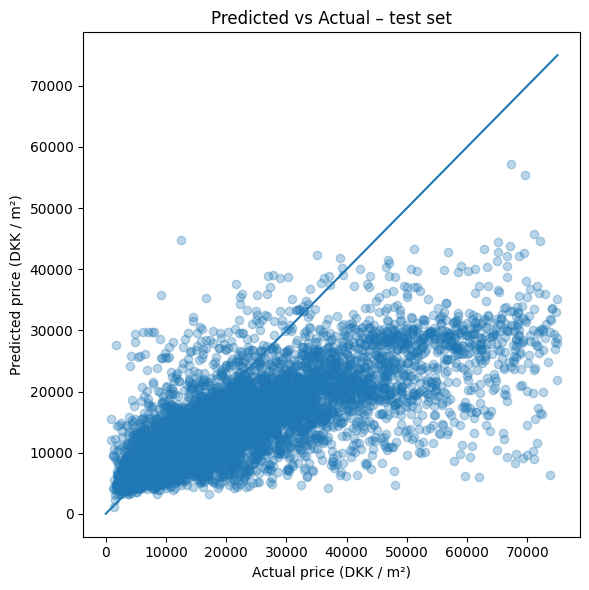

In [11]:
import matplotlib.pyplot as plt

# Take a sample from test predictions (to avoid pulling millions of rows)
sample_pd = (
    pred_test
    .select("actual_price_m2", "pred_price_m2")
    .sample(False, 0.05, seed=42)   # ~5% of test
    .toPandas()
)

plt.figure(figsize=(6, 6))
plt.scatter(sample_pd["actual_price_m2"], sample_pd["pred_price_m2"], alpha=0.3)
max_val = max(sample_pd["actual_price_m2"].max(), sample_pd["pred_price_m2"].max())
plt.plot([0, max_val], [0, max_val])          # perfect prediction line

plt.xlabel("Actual price (DKK / m²)")
plt.ylabel("Predicted price (DKK / m²)")
plt.title("Predicted vs Actual – test set")
plt.tight_layout()
plt.show()


# MAPE BY REGION

          region      mape
0        Zealand  0.347637
1  Fyn & islands  0.348015
2        Jutland  0.358761
3       Bornholm  0.364155


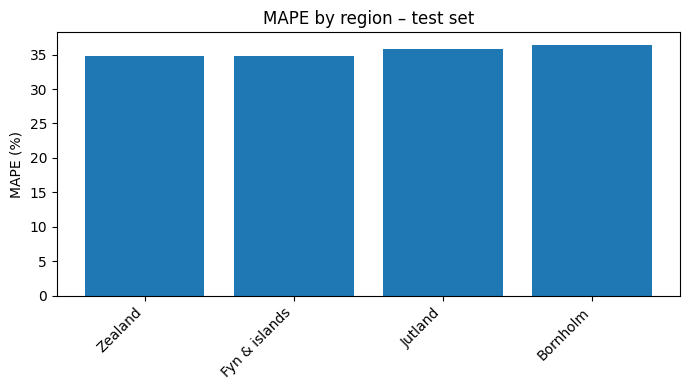

In [12]:
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

# Join predictions with region + city info
# df_with_label has label_log_sqm_price, region, city, date, sqm_price, etc.
pred_with_region = (
    pred_test
    .join(
        df_with_label.select(
            F.col("label_log_sqm_price").alias("label"),
            "region",
            "city",
            "date",
            "sqm_price"
        ),
        on="label",
        how="left"
    )
)

# Compute MAPE per region
mape_by_region = (
    pred_with_region
    .withColumn(
        "abs_percent_error",
        F.abs(F.col("pred_price_m2") - F.col("actual_price_m2")) / F.col("actual_price_m2")
    )
    .groupBy("region")
    .agg(F.mean("abs_percent_error").alias("mape"))
    .orderBy("mape")
)

mape_region_pd = mape_by_region.toPandas()

print(mape_region_pd)

# Bar plot
plt.figure(figsize=(7, 4))
plt.bar(mape_region_pd["region"], mape_region_pd["mape"] * 100)
plt.ylabel("MAPE (%)")
plt.title("MAPE by region – test set")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()
